## IMPORT LIBS

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline
print('imported')

imported


## IMPORT DATA

In [2]:
vehicles=glob.glob('vehicles/**/*.png')
not_vehicles=glob.glob('non-vehicles/**/*.png')

print('# of vehicle images:',len(vehicles))
print('# of NOT vehicle images:',len(not_vehicles))


# of vehicle images: 8792
# of NOT vehicle images: 8968


In [3]:
def plot2imgs(im1,im2,txt1,txt2):        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(txt1, fontsize=20)
    ax2.imshow(im2)
    ax2.set_title(txt2, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
def plot3imgs(im1,im2,im3,txt1,txt2,txt3):        
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(txt1, fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(txt2, fontsize=50)
    ax3.imshow(im3)
    ax3.set_title(txt3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

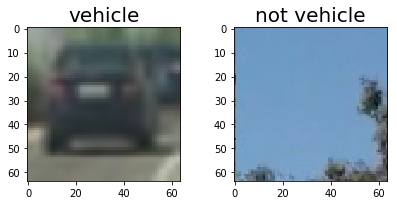

In [4]:
vehicle_img=mpimg.imread(vehicles[0])
not_vehicle_img=mpimg.imread(not_vehicles[0])

plot2imgs(vehicle_img,not_vehicle_img,'vehicle','not vehicle')
plt.savefig('datavisual.jpg')    


In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace, spatial_size,
                        hist_bins, hist_range,pixel_per_cell,cell_per_block,orient,feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        hog_features =get_hog_features(feature_image,orient,pixel_per_cell,cell_per_block,False,feature_vec)
        
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    #X_scaler = StandardScaler().fit(features)
    # Apply the scaler to X
    #features = X_scaler.transform(features)
    # Return list of feature vectors
    return features

def single_img_features(img,  cspace, spatial_size,hist_bins, hist_range,pixel_per_cell,cell_per_block,orient,feature_vec=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    
    spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
    img_features.append(spatial_features)
   
    hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
    img_features.append(hist_features)
  
    hog_features =get_hog_features(feature_image,orient,pixel_per_cell,cell_per_block,False,feature_vec)

        #8) Append features to list
    img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

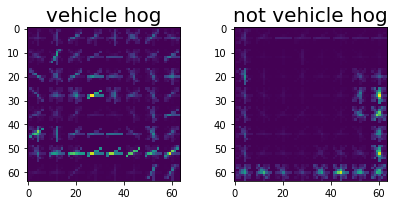

In [6]:
pixel_per_cell =8
cspace ='LUV'
cell_per_block =2
orient =8
spatial_size = (16,16)
bins=32
hist_range=(0,256)

_,vehicle_hog=get_hog_features(vehicle_img,orient,pixel_per_cell,cell_per_block,True,True)
_,not_vehicle_hog=get_hog_features(not_vehicle_img,orient,pixel_per_cell,cell_per_block,True,True)

plot2imgs(vehicle_hog,not_vehicle_hog,'vehicle hog','not vehicle hog')
plt.savefig('hog_sample.jpg')    


In [7]:
vehicle_features=extract_features(vehicles,cspace,spatial_size,bins,hist_range,pixel_per_cell,cell_per_block,orient)

not_vehicle_features=extract_features(not_vehicles,cspace,spatial_size,bins,hist_range,pixel_per_cell,cell_per_block,orient)

print('features are extracted')

features are extracted


In [8]:
print(len(vehicle_features[0]))
print(len(not_vehicle_features))

2432
8968


In [9]:
inputset = np.vstack((vehicle_features, not_vehicle_features)).astype(np.float64)  
X_scaler = StandardScaler().fit(inputset)
    # Apply the scaler to X
inputset = X_scaler.transform(inputset)
labels= np.hstack((np.ones(len(vehicle_features)), np.zeros(len(not_vehicle_features))))
print('shape of inputset',inputset.shape)
print('shape of labels',labels.shape)

train_set,test_set,train_label,test_label=train_test_split(inputset,labels,test_size=0.2)

shape of inputset (17760, 2432)
shape of labels (17760,)


In [10]:
svc =LinearSVC()

svc.fit(train_set,train_label)

print('training is completed')

training is completed


In [11]:
accuraacy=svc.score(test_set,test_label)
print('accuracy is:',accuraacy)

accuracy is: 0.977477477477


In [12]:
def draw_rectangles(img, recs, color=(0, 0, 255), thick=6):
    image = np.copy(img) # Make a copy of the image
    for rec in recs: # Iterate through the bounding boxes
        cv2.rectangle(image, rec[0], rec[1], color, thick)
    return image

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [13]:
def detect_vehicles(img, ystart, ystop, scale, cspace, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    rects=[]
    img = img.astype(np.float32)/255

    cropped=img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2YCrCb)
    else: pass

    if scale != 1:
        imshape = cropped.shape
        scaled = cv2.resize(cropped, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    else: scaled=cropped
    
    hog = get_hog_features(scaled, orient, pix_per_cell, cell_per_block, vis=False,feature_vec=False)
    ch1=scaled[:,:,0]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
 
 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(scaled[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_feat)).reshape(1, -1))    
            #test_features=(np.concatenate((spatial_features, hist_features,hog_feat)))

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rects

    

test_img=mpimg.imread('test_images/test4.jpg')
#plt.imshow(test_img)
#print(test_img.shape)
recs=detect_vehicles(test_img,400,600,1,cspace,svc,X_scaler,orient,pixel_per_cell,cell_per_block,spatial_size,bins,False)


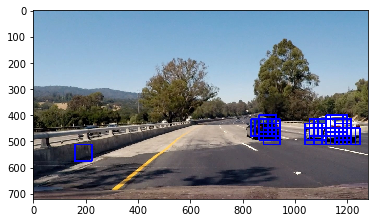

In [14]:

output=draw_rectangles(test_img,recs)
plt.imshow(output)
plt.savefig('rawoutput.jpg')    


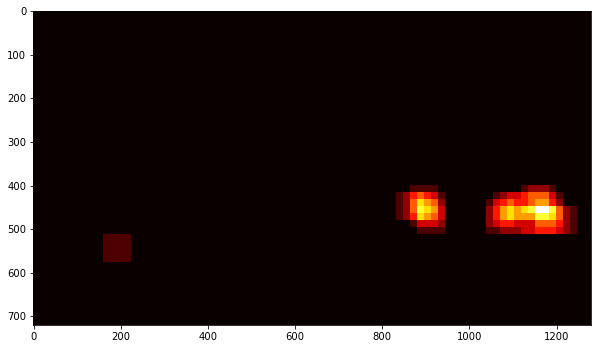

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    newmap=np.copy(heatmap)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        newmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return newmap
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, recs)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('heatmap.jpg')    


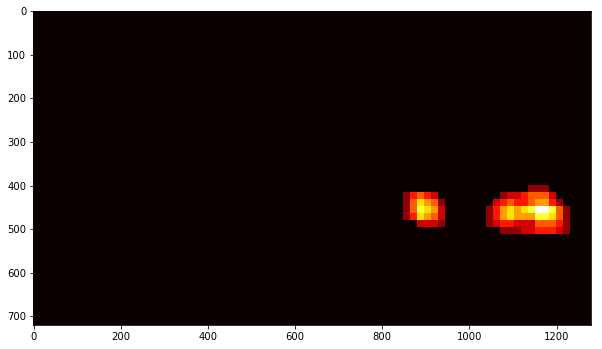

In [16]:

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    newmap=np.copy(heatmap)
    newmap[newmap <= threshold] = 0
    # Return thresholded map
    return newmap
heatmap_image = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')
plt.savefig('heatmap_filtered.jpg')    


2 cars found


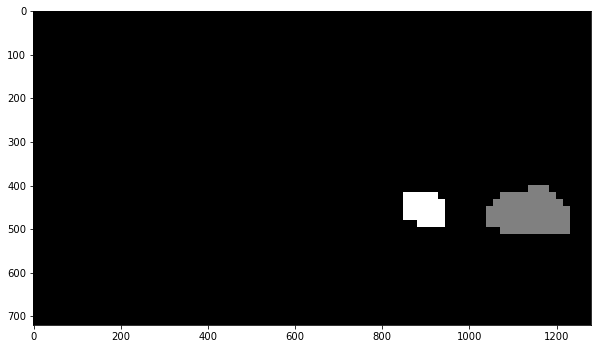

In [17]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.savefig('labeled.jpg')    


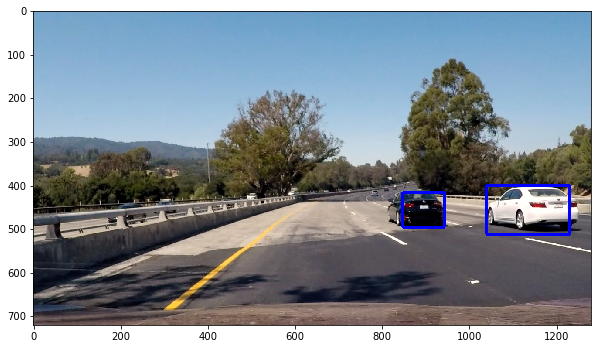

In [18]:
def draw_labeled_bboxes(img, labels):
        #implemented from fellow udacian

    # Iterate through all detected cars
    myimg=np.copy(img)
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        boundingbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(boundingbox)
        # Draw the box on the image
        cv2.rectangle(myimg, boundingbox[0], boundingbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return myimg, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

plt.savefig('finalimage.jpg')    


In [19]:
def detect_vehicle_in_video(img):
    pixel_per_cell =8
    cspace ='LUV'
    cell_per_block =2
    orient =8
    spatial_size = (16,16)
    bins=32
    hist_range=(0,256)
    
    ystart = 400
    ystop = 500
    scale = 1.0
    rectangles=[]
    rectangles.append(detect_vehicles(img,ystart,ystop,scale,cspace,svc,X_scaler,orient,pixel_per_cell,cell_per_block,spatial_size,bins,False))
    ystart = 460
    ystop = 660
    scale = 2
    rectangles.append(detect_vehicles(img,ystart,ystop,scale,cspace,svc,X_scaler,orient,pixel_per_cell,cell_per_block,spatial_size,bins,False))
    #implemented from fellow udacian's code
    rectangles = [item for sublist in rectangles for item in sublist] 
   

    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

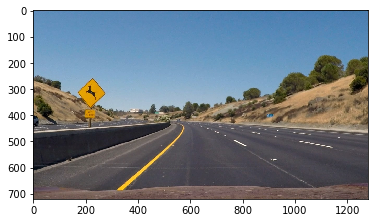

In [20]:
test_img=mpimg.imread('test_images/test2.jpg')
out=detect_vehicle_in_video(test_img)
plt.imshow(out)


In [21]:

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicle_in_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:10<00:00,  3.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 11.8 s


In [22]:

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicle_in_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:53<00:00,  3.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 5min 54s
